In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create a simple CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

11490434/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 650 (2.54 KB)
Trainable params: 650 (2.54 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [ ]:
# Train the model (you can adjust epochs and batch size as needed)
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
469/469 [==============================] - 17s 34ms/step - loss: 2.2266 - accuracy: 0.2011 - val_loss: 2.1097 - val_accuracy: 0.2914
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 1.9863 - accuracy: 0.3131 - val_loss: 1.8758 - val_accuracy: 0.3407
Epoch 3/10
469/469 [==============================] - 14s 31ms/step - loss: 1.8105 - accuracy: 0.3563 - val_loss: 1.7441 - val_accuracy: 0.3737
Epoch 4/10
469/469 [==============================] - 11s 23ms/step - loss: 1.7084 - accuracy: 0.3854 - val_loss: 1.6595 - val_accuracy: 0.4001
Epoch 5/10
469/469 [==============================] - 11s 23ms/step - loss: 1.6418 - accuracy: 0.4039 - val_loss: 1.6007 - val_accuracy: 0.4331
Epoch 6/10
469/469 [==============================] - 11s 23ms/step - loss: 1.5933 - accuracy: 0.4228 - val_loss: 1.5557 - val_accuracy: 0.4376
Epoch 7/10
469/469 [==============================] - 11s 23ms/step - loss: 1.5547 - accuracy: 0.4354 - val_loss: 1.5190 - val_accuracy:

In [ ]:
# Define Grad-CAM function
def grad_cam(input_model, image):
    x = np.expand_dims(image, axis=0)
    preds = input_model.predict(x)
    last_conv_layer = input_model.get_layer('conv2d')  # Get the last convolutional layer
    last_conv_layer_model = tf.keras.Model(input_model.inputs, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    y = classifier_input
    for layer_name in ["global_average_pooling2d", "dense"]:
        y = model.get_layer(layer_name)(y)
    classifier_model = tf.keras.Model(classifier_input, y)

    with tf.GradientTape() as tape:
      inputs = image[np.newaxis, ...]
      last_conv_layer_output = last_conv_layer_model(inputs)
      print(last_conv_layer_output)
      tape.watch(last_conv_layer_output)
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]
      print(top_pred_index)

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (28, 28))
    return gradcam

In [ ]:
grad_cam = grad_cam(model, X_test[0])

1/1 [==============================] - 0s 86ms/step
tf.Tensor(
[[[[0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   ...
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]]

  [[0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   ...
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.        0.9911495 ... 0.        0.        0.       ]]

  [[0.        0.        0.9911495 ... 0.        0.        0.       ]
   [0.        0.      

(28, 28, 1)


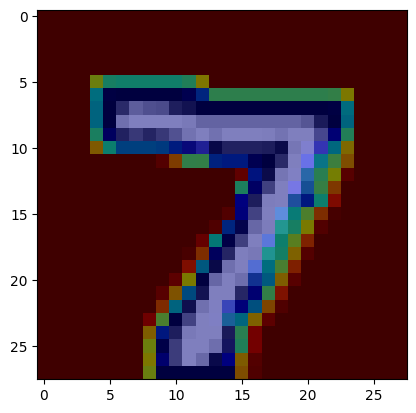

In [ ]:
plt.imshow(X_test[0].squeeze(), cmap='gray')
print(X_test[0].shape)
plt.imshow(grad_cam, alpha=0.5, cmap='jet')